In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
#os.environ['WEBBPSF_PATH'] = 
import webbpsf
from webbpsf import wfirst
import ipywidgets
from astropy.io import fits

In [3]:
webbpsf.setup_logging()

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.


In [4]:
ifs_spc = wfirst.CGI()
ifs_spc.mode = 'CHARSPC_F770'

filter_fname = ifs_spc._filters[ifs_spc.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)
deltalam_ifs = float(filter_hdulist[1].header.get('LAMBDA0'))/170. # Assume spectral resolution R = 70
Nchan = (int(np.floor((wave_end - wave_beg)/deltalam_ifs))//2)*2 + 1 # Number of channels, forced to an odd integer
wavelens = np.linspace(wave_beg, wave_end, Nchan) * 1e-10 # all wavelengths to model, in meters

lamoD_asec = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*ifs_spc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D) in arcsec: %.3f" % lamoD_asec)
print("IFS spectral parameters: %d channels of characteristic spectral width %.2f nm," % (Nchan,deltalam_ifs/10.))
print("ranging from %d nm to %d nm, centered on %d nm" % (wavelens[0]*1e9, wavelens[-1]*1e9, wavelens[Nchan//2]*1e9))
filter_hdulist.close()

[webbpsf] Printing the table of WFIRST CGI observing modes supported by WebbPSF.
[webbpsf] Each is defined by a combo of camera, filter, apodizer, focal plane mask (FPM), and Lyot stop settings:
[webbpsf] {'CHARSPC_F660': ('IFS', 'F660', 'CHARSPC', 'CHARSPC_F660_BOWTIE', 'LS30D88'),
 'CHARSPC_F770': ('IFS', 'F770', 'CHARSPC', 'CHARSPC_F770_BOWTIE', 'LS30D88'),
 'CHARSPC_F890': ('IFS', 'F890', 'CHARSPC', 'CHARSPC_F890_BOWTIE', 'LS30D88'),
 'DISKSPC_F721': ('IMAGER',
                  'F721',
                  'DISKSPC',
                  'DISKSPC_F721_ANNULUS',
                  'LS30D88')}
[webbpsf] Since the mode was not specified at instantiation, defaulting to CHARSPC_F660
[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F660, apodizer = CHARSPC, fpm = CHARSPC_F660_BOWTIE, lyotstop = LS30D88
[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F770, apodizer = CHARSPC, fpm = CHARSPC_F770_BOWTIE, lyotstop = LS30D88
Sys

In [5]:
ifs_spc.options['source_offset_r'] = 0 # arcsec
ifs_spc.options['source_offset_theta'] = 0 # deg w.r.t. North

ifs_psf_onax = ifs_spc.calc_datacube(wavelens, fov_arcsec=1.64, oversample=4, display=False)
print("The resulting data cube has dimensions {} wavelengths x {} pixels x {} pixels".format\
      (ifs_psf_onax[1].data.shape[0], ifs_psf_onax[1].data.shape[1], ifs_psf_onax[1].data.shape[2]))

[  poppy] Starting multiwavelength data cube calculation.
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 1.640000, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/CGI

In [6]:
ifs_spc.options['source_offset_r'] = 6*lamoD_asec # 6 lam/D in arcsec
ifs_spc.options['source_offset_theta'] = -90. # deg w.r.t. North

ifs_psf_offax = ifs_spc.calc_datacube(wavelens, fov_arcsec=1.64, oversample=4, display=False)
offax_peak_vec = np.max(np.max(ifs_psf_offax[1].data, axis=-1), axis=-1)
offax_peak_cube = np.tile(offax_peak_vec[:,np.newaxis,np.newaxis],
                          (1, ifs_psf_onax[1].data.shape[-2], ifs_psf_onax[1].data.shape[-1]))

ifs_psf_onax_contrast = ifs_psf_onax[1].data / offax_peak_cube

[  poppy] Starting multiwavelength data cube calculation.
[  poppy] Monochromatic calculation requested.
[  poppy] PSF calc using fov_arcsec = 1.640000, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude transmission from /Users/mrizzo/IFS/webbpsf-data/CGI

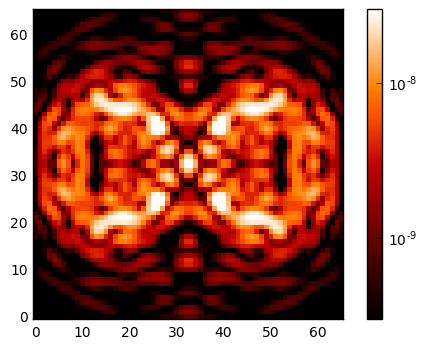

In [7]:
def plt_ifs_psf_onax(wchan):
    plt.imshow(ifs_psf_onax_contrast[wchan-1], norm=matplotlib.colors.LogNorm(),
               vmin=3e-10, vmax=3e-8, cmap='gist_heat')
    plt.colorbar()
ipywidgets.interact(plt_ifs_psf_onax, wchan=(1,Nchan));


In [8]:
from tools.image import Image
Image(data=ifs_psf_onax_contrast).write('ifs_psf_onax_contrast.fits')

In [9]:
print(np.array(wavelens.T*1e6))
print(len(wavelens))

[ 0.7007   0.70532  0.70994  0.71456  0.71918  0.7238   0.72842  0.73304
  0.73766  0.74228  0.7469   0.75152  0.75614  0.76076  0.76538  0.77
  0.77462  0.77924  0.78386  0.78848  0.7931   0.79772  0.80234  0.80696
  0.81158  0.8162   0.82082  0.82544  0.83006  0.83468  0.8393 ]
31


In [10]:
from IFS import propagateIFS
import numpy as np
from params import Params
from astropy.io import fits as pyf
import time
import logging as log
from tools.initLogger import initLogger


In [11]:
# load parameters
par = Params()
print(par.output())


Number of lenslets: 108
Lenslet pitch in meters: 0.000174
Interlacing: 2
Rotation angle: 0.463647609001
Pinhole? True
Pinhole diameter: 2.5e-05
Number of pixels in final detector: 1024
Detector pixel size in meters: 1.3e-05
Oversampling: 11
Convolve with Gaussian as defocus? True
FWHM of Gaussian convolution 2 detector pixel



In [12]:
# initalize logger; both console and text file
#initLogger(par.exportDir+'/IFS.log')
log.info('Loading input')

In [13]:
# need to figure out the scale of the incoming cube...
mperpix = 3./4.*par.pitch
par.pixperlenslet = par.pitch/mperpix
par.mperpix = mperpix
wavlist = np.linspace(605,725,31)

In [14]:
finalFrame = propagateIFS(par,wavlist*1e-3,ifs_psf_onax_contrast,parallel=False)

[   root] Wavelength out of range of reference kernels
/Users/mrizzo/IFS/IFS-Simulator/tools/lenslet.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  paddedImagePlane = np.zeros((imagePlane.shape[0]*np.sqrt(2),imagePlane.shape[1]*np.sqrt(2)))
/Users/mrizzo/IFS/IFS-Simulator/tools/lenslet.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  paddedImagePlane[xpad:-xpad-1,ypad:-ypad-1] = imagePlane
/Users/mrizzo/IFS/IFS-Simulator/tools/detutils.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  temp = np.zeros((shape[1], x),dtype=float)
/Users/mrizzo/IFS/IFS-Simulator/tools/detutils.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = np.zeros((shape[0], shape[1]), dtype=float)
/Users/mrizzo/IFS/IFS

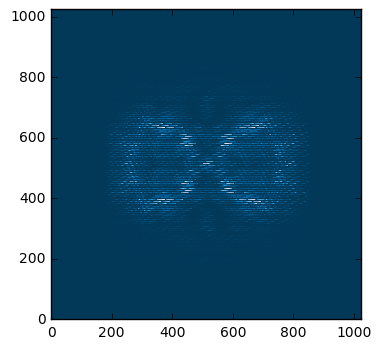

In [15]:
pylab.imshow(finalFrame, cmap='PuBu_r')

In [16]:
from IFS import reduceIFSMap
fname='/Users/mrizzo/IFS/IFS-Simulator/SimResults/detectorFrame.fits'
par.R=110
cube = reduceIFSMap(par,fname,method='intopt',ivar=False)


/Users/mrizzo/IFS/IFS-Simulator/tools/reduction.py:548: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  pix_center_vals = [np.sum(im.data[i1:i1 + delt_y, val]*gaussian) for val in ix]/weights


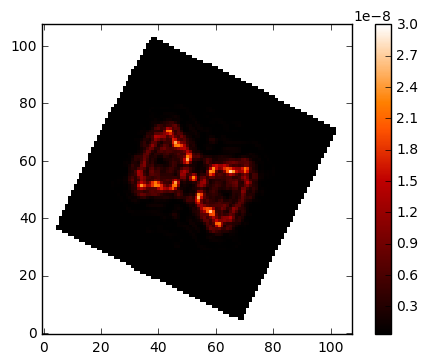

In [18]:
from tools.image import Image
Image(data=cube).write('/Users/mrizzo/IFS/IFS-Simulator/SimResults/detectorFrame_red_intopt3.5.fits')
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

import ipywidgets

def plt_ifs_intopt(wchan):
    plt.imshow(cube[wchan-1,:,:], #norm=matplotlib.colors.LogNorm(),
               vmin=3e-10, vmax=3e-8, cmap='gist_heat')
    plt.colorbar()
ipywidgets.interact(plt_ifs_intopt, wchan=(1,cube.shape[0]));
